# Lab 3: Linear and logistic regression
Import and explore the data, implements python functions to (i) learn linear regression models and (ii) learn logistic regression models. Submit this notebook to eclass with the name "lab3_123456.ipynb" and replace "123456" by the ID you used for the first lab.

In [39]:
import numpy as np
import pandas as pd
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re

Import the data in "housing.txt", "occupacy_training_set.csv", "occupacy_test_set_1.csv" and "occupacy_test_set_2.csv" datasets

In [40]:
#make sure to separate the dataponts and the labels (into arrays X and y)
#for housing, NOX and MEDV should not be present in X
#y should contain MEDV
housing = pd.read_csv("housing.txt", sep=r'\s+', header=None)
X_housing = housing.drop(columns=[4, 13]).values
y_housing = housing.iloc[:, -1].values.reshape(-1, 1)

occ_train = pd.read_csv("occupancy_training_set.csv")
occ_test1 = pd.read_csv("occupancy_test_set_1.csv")
occ_test2 = pd.read_csv("occupancy_test_set_2.csv")

X_occ_train = occ_train.iloc[:, :-1].values
y_occ_train = occ_train.iloc[:, -1].values.reshape(-1, 1)
X_occ_val = occ_test1.iloc[:, :-1].values
y_occ_val = occ_test1.iloc[:, -1].values.reshape(-1, 1)
X_occ_test = occ_test2.iloc[:, :-1].values
y_occ_test = occ_test2.iloc[:, -1].values.reshape(-1, 1)

Divide your dataset into training and testing sets (occupacy is already separated, choose one of the test sets as validation set)

In [41]:
#your code goes here
Xtrain_r_raw, Xtest_r_raw, ytrain_r, ytest_r = train_test_split(X_housing, y_housing, test_size=0.3, random_state=42)

Check the scale of the values of housing features. TIP: consider normalizing your dataset.

In [42]:
#your code goes here
X_min = Xtrain_r_raw.min(axis=0)
X_max = Xtrain_r_raw.max(axis=0)
Xtrain_r = (Xtrain_r_raw - X_min) / (X_max - X_min)
Xtest_r = (Xtest_r_raw - X_min) / (X_max - X_min)

Create a function that estimate the parameters of a linear regression model using the closed form solution to fit the data.

In [43]:
def LiR_c(Xtrain, ytrain):
    """
    Linear Regression - Solução Fechada (Closed Form)
    """
    X_bias = np.insert(Xtrain, 0, 1, axis=1)
    w = np.linalg.pinv(X_bias) @ ytrain
    return w

Create a function that estimate the parameters of a linear regression model using stochastic gradient descent iterative procedure. Your function should output a vector containing the value of the loss at each gradient update besides the linear regression model parameters.

In [44]:
def LiR_gd(Xtrain, ytrain, lr=0.001, max_iter=100):
    """
    Linear Regression - Stochastic Gradient Descent (SGD)
    """
    X_bias = np.insert(Xtrain, 0, 1, axis=1)
    w = np.random.normal(scale=0.01, size=(X_bias.shape[1], 1))
    loss = []

    for epoch in range(max_iter):
        indices = np.random.permutation(Xtrain.shape[0])
        for i in indices:
            xi = X_bias[i].reshape(-1, 1)
            yi = ytrain[i]
            gradient = (yi - w.T @ xi) * xi
            w += lr * gradient

        y_pred = X_bias @ w
        sse = np.mean((ytrain - y_pred) ** 2) / 2
        loss.append(sse)

    return w, loss

Train two linear regression models using your training set of the housing dataset, the parameters of one model using the closed form solution  and the parameters of the second model using the stochastic gradient descent procedure. Print the parameters for both procedures and plot the loss at each parameter update.

Parametros do modelo (Closed Form): [ 23.80195221 -10.88158358   3.5761525   -0.41164626   2.99832557
  20.38736905  -2.40170604 -12.66224434   4.66430589  -5.19334848
  -6.90826839   4.82220904 -20.7831857 ]
Parametros do modelo (SGD): [ 12.52736682  -2.46675778   3.12147943  -1.18873044   5.00208101
  18.88892983   1.54805968  -0.71694265   0.74335717  -1.68694246
  -5.61170765   8.37127442 -13.36857971]


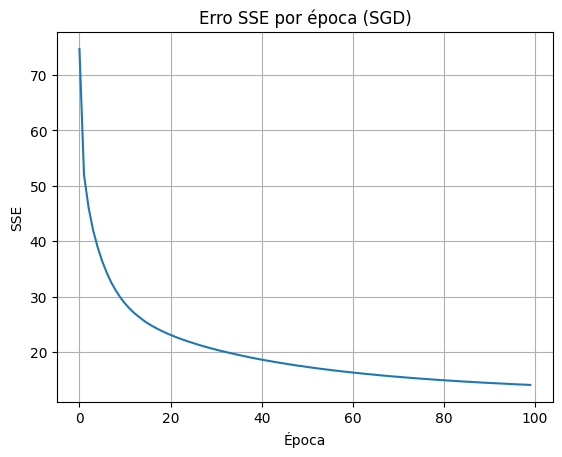

In [45]:
#your code here
w_c = LiR_c(Xtrain_r, ytrain_r)
y_pred_c = np.insert(Xtest_r, 0, 1, axis=1) @ w_c

w_s, sse_hist = LiR_gd(Xtrain_r, ytrain_r, lr=0.001, max_iter=100)
y_pred_s = np.insert(Xtest_r, 0, 1, axis=1) @ w_s

print("Parametros do modelo (Closed Form):", w_c.flatten())
print("Parametros do modelo (SGD):", w_s.flatten())

plt.plot(sse_hist)
plt.title("Erro SSE por época (SGD)")
plt.xlabel("Época")
plt.ylabel("SSE")
plt.grid()
plt.show()

Build a function that uses the learned parameters w to predict the value (MEDV in our dataset) for new datapoints.

In [46]:
def predLiR(w, Xtest):
    X_bias = np.insert(Xtest, 0, 1, axis=1)
    preds = X_bias @ w
    return preds

Use your trained parameters of linear regression and your predLiR() function to predict for your test set of the housing dataset

In [47]:
#your code goes here
y_pred_c = predLiR(w_c, Xtest_r)
y_pred_s = predLiR(w_s, Xtest_r)

Evaluate your predictions using the Root Mean Square Error. 

In [48]:
#your code goes here
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

rmse_c = rmse(ytest_r, y_pred_c)
rmse_s = rmse(ytest_r, y_pred_s)

print(f"RMSE - Closed Form: {rmse_c:.4f}")
print(f"RMSE - SGD: {rmse_s:.4f}")


RMSE - Closed Form: 4.8020
RMSE - SGD: 5.2090


Build a function that learns the parameters of a logistic regression model given a dataset using a stochastic gradient descent strategy. The function should output a vector wih the loss values during training.

In [49]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def LoR_gd(Xtrain, ytrain, lr=0.01, max_iter=100):
    X_bias = np.insert(Xtrain, 0, 1, axis=1)
    w = np.random.normal(scale=0.01, size=(X_bias.shape[1], 1))
    loss = []

    for epoch in range(max_iter):
        indices = np.random.permutation(Xtrain.shape[0])
        for i in indices:
            xi = X_bias[i].reshape(-1, 1)
            yi = ytrain[i]
            p = sigmoid(w.T @ xi)
            grad = (p - yi) * xi
            w -= lr * grad

        z_all = X_bias @ w
        p_all = sigmoid(z_all)
        ce = -np.mean(ytrain * np.log(p_all + 1e-10) + (1 - ytrain) * np.log(1 - p_all + 1e-10))
        loss.append(ce)

    return w, loss

Build a function that learns the parameters of a logistic regression model given a dataset using the reweighted least squares algorithm. The function should output a vector wih the loss values during training.

In [50]:
def LoR_2(Xtrain,ytrain,max_iter):
    X_bias = np.insert(Xtrain, 0, 1, axis=1)
    w = np.zeros((X_bias.shape[1], 1))
    loss = []

    for _ in range(max_iter):
        z = X_bias @ w
        p = sigmoid(z)
        W = np.diag((p * (1 - p)).flatten())
        H = X_bias.T @ W @ X_bias
        g = X_bias.T @ (ytrain - p)
        w += np.linalg.pinv(H) @ g

        ce = -np.mean(ytrain * np.log(p + 1e-10) + (1 - ytrain) * np.log(1 - p + 1e-10))
        loss.append(ce)

    return w, loss

In [51]:
# Calcular a média e o desvio padrão nos dados de treino
mean_train = np.mean(X_occ_train, axis=0)
std_train = np.std(X_occ_train, axis=0)

# Normalizar os dados de treino
X_occ_train_scaled = (X_occ_train - mean_train) / std_train

# Normalizar os dados de validação e teste com a mesma média e desvio padrão dos dados de treino
X_occ_val_scaled = (X_occ_val - mean_train) / std_train
X_occ_test_scaled = (X_occ_test - mean_train) / std_train

Train the 2 logistic regression models, each learned with the above learning functions, using the training set of the Occupacy dataset. Plot the loss for both procedure (remeber to include titles and legends)

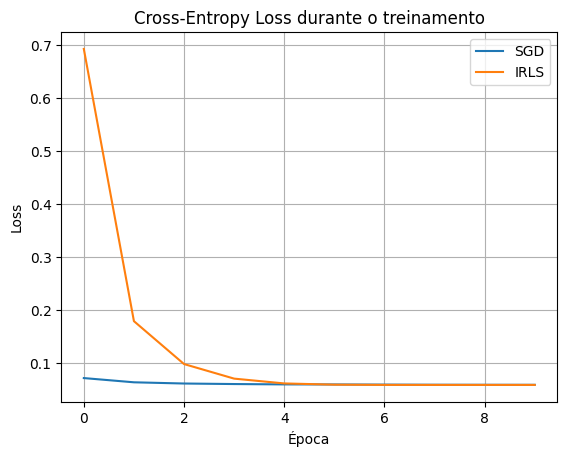

In [52]:
#your code goes here
w_sgd, ce_sgd = LoR_gd(X_occ_train_scaled, y_occ_train, lr=0.01, max_iter=10)
w_irls, ce_irls = LoR_2(X_occ_train_scaled, y_occ_train, max_iter=10)

plt.plot(ce_sgd, label="SGD")
plt.plot(ce_irls, label="IRLS")
plt.title("Cross-Entropy Loss durante o treinamento")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

Build a function that predict the class of a point using a logistic regresion model and a treshold.

In [53]:
def pred_LoR(Xtest,w, threshold=0.5):
    X_bias = np.insert(Xtest, 0, 1, axis=1)
    p = sigmoid(X_bias @ w)
    return (p >= threshold).astype(int)

Predict for the validation set of the occupacy dataset. Try different tresholds for classiffication and check the recall and precision for this different tresholds. 

In [54]:
#your code goes here
def calculate_precision_recall(y_true, y_pred):
    # Calculando os componentes da matriz de confusão
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    false_positives = np.sum((y_true == 0) & (y_pred == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred == 0))

    # Precision e Recall
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0

    return precision, recall

def evaluate_model(X_val, y_val, params, thresholds):
    for threshold in thresholds:
        # Previsões usando o threshold
        y_pred = pred_LoR(X_val, params, threshold)

        # Calcular precisão e recall manualmente
        precision, recall = calculate_precision_recall(y_val, y_pred)

        print(f"Threshold: {threshold} | Precision: {precision:.4f} | Recall: {recall:.4f}")

# Definir diferentes thresholds para testar
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

# Avaliar o modelo SGD
print("Modelo SGD:")
evaluate_model(X_occ_val_scaled, y_occ_val, w_sgd, thresholds)

print("\nModelo IRLS:")
# Avaliar o modelo IRLS
evaluate_model(X_occ_val_scaled, y_occ_val, w_irls, thresholds)

Modelo SGD:
Threshold: 0.3 | Precision: 0.9473 | Recall: 0.9979
Threshold: 0.4 | Precision: 0.9472 | Recall: 0.9969
Threshold: 0.5 | Precision: 0.9471 | Recall: 0.9949
Threshold: 0.6 | Precision: 0.9465 | Recall: 0.9835
Threshold: 0.7 | Precision: 0.9647 | Recall: 0.9558

Modelo IRLS:
Threshold: 0.3 | Precision: 0.9473 | Recall: 0.9979
Threshold: 0.4 | Precision: 0.9472 | Recall: 0.9959
Threshold: 0.5 | Precision: 0.9466 | Recall: 0.9846
Threshold: 0.6 | Precision: 0.9470 | Recall: 0.9743
Threshold: 0.7 | Precision: 0.9670 | Recall: 0.9331


Train 2 new logistic regresion models, one for each training squeme, using a set of the union of validation and training. Choose the best treshold from your experiment in the last cell and predict for the points in the test set. Use a barplot to show the accuracy, recall and precision for both leaned logitic regression models.

In [55]:
#your code goes here
def acc(pred, target):
    # accuracy = number of correct predictions / total number of predictions
    accuracy = np.count_nonzero(pred == target)  / len(target)
    return accuracy

def calculate_metrics(y_true, y_pred):
    precision, recall = calculate_precision_recall(y_true, y_pred)
    accuracy = acc(y_pred, y_true)
    return precision, recall, accuracy

# Normaliza os dados
X_combined = np.vstack((X_occ_train, X_occ_val))
y_combined = np.vstack((y_occ_train, y_occ_val))

mean_train = np.mean(X_combined, axis=0)
std_train = np.std(X_combined, axis=0)

X_combined_norm = (X_combined - mean_train) / std_train
X_occ_train_norm = (X_occ_train - mean_train) / std_train
X_occ_val_norm = (X_occ_val - mean_train) / std_train
X_occ_test_norm = (X_occ_test - mean_train) / std_train

# Treina os modelos
w_lor2, _ = LoR_2(X_combined_norm, y_combined, max_iter=100)
w_lorgd, _ = LoR_gd(X_combined_norm, y_combined, lr=0.01, max_iter=100)

#Prevesões para o conjunto de teste
best_threshold = 0.3

y_pred_lor2 = pred_LoR(X_occ_test_norm, w_lor2, threshold=best_threshold)
y_pred_lorgd = pred_LoR(X_occ_test_norm, w_lorgd, threshold=best_threshold)

# Calculo das metricas
precision_lor2, recall_lor2, accuracy_lor2 = calculate_metrics(y_occ_test, y_pred_lor2)
precision_lorgd, recall_lorgd, accuracy_lorgd = calculate_metrics(y_occ_test, y_pred_lorgd)

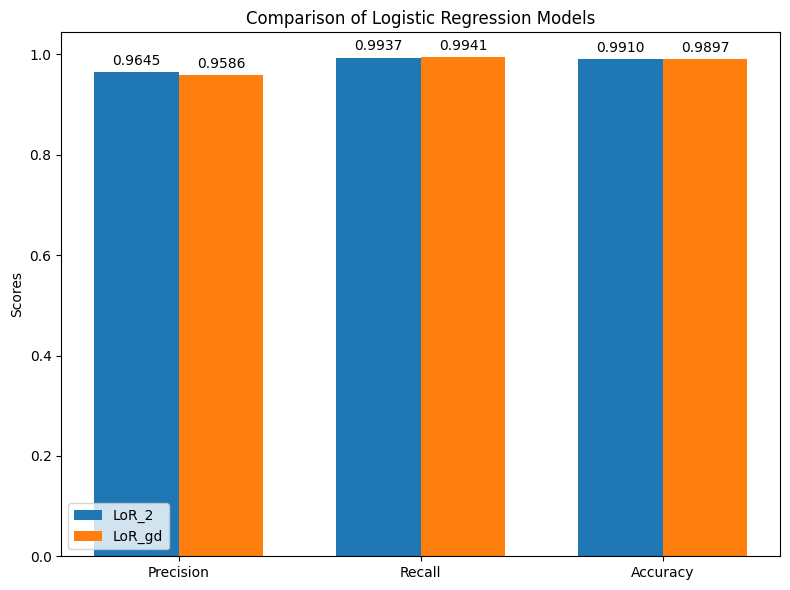

In [56]:

# Plotar as métricas em um gráfico de barras
metrics = ['Precision', 'Recall', 'Accuracy']
lor2_metrics = [precision_lor2, recall_lor2, accuracy_lor2]
lorgd_metrics = [precision_lorgd, recall_lorgd, accuracy_lorgd]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

rects1 = ax.bar(x - width/2, lor2_metrics, width, label='LoR_2')
rects2 = ax.bar(x + width/2, lorgd_metrics, width, label='LoR_gd')

# Adicionar rótulos, título e legendas
ax.set_ylabel('Scores')
ax.set_title('Comparison of Logistic Regression Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Função para adicionar os rótulos nas barras
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Adicionar os rótulos nas barras
add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()